# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hdc

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np

In [34]:
# connect to devices
pg  = PulseGenerator(ip=hdc.PS_IP, chmap=hdc.PS_chmap) 
mwsyn = Synthesizer(hdc.VDISYN_SN, 
                    vidpid=hdc.VDISYN_VIDPID,
                    baudrate=hdc.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hdc.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [35]:
current_percent = 99.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [36]:
freq = 16.6
errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.6 GHz
Actual Output CW Freqeuncy :16.600000005215406 GHz


In [37]:
dur_pt = 16E6 # duration of each frequency point
divpart_pt = 2 # duration of each frequency point
clock_rate = 500E-6 #GHz
daqtrig_delay = 1/clock_rate #delay
seq_daqtrig = [(dur_pt/2.0, HIGH), (dur_pt/2.0, LOW)]
seq_laser = [(dur_pt, HIGH)]
seq_mwA = [(dur_pt/2.0/divpart_pt, HIGH), (dur_pt/2.0/divpart_pt, LOW)]*divpart_pt
seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*int(dur_pt*clock_rate)
pg.setDigital("laser", seq_laser)
pg.setDigital("mw_A", seq_mwA)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("daqtrig", seq_daqtrig)
pg.setDigital("clock", seq_clock)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)

In [31]:
readtask.close()

In [38]:
# signal reading parameters
min_volt = -0.01 # [V]
max_volt = 0.04
samplerate_read = clock_rate*1E9 # 500kHz .max ext clock rate of NI6343
basetime = 1.0/samplerate_read
num_readsample = int(samplerate_read*dur_pt/1E9)
timeout_read = max(dur_pt*2.0/1E9, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hdc.DAQch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
readtask.timing.cfg_samp_clk_timing(samplerate_read, source=hdc.DAQch_Clock, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hdc.DAQch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
        # reader = stream_readers.AnalogMultiChannelReader(task.in_stream)
reader.read_all_avail_samp  = True
divnum = int(len(buffer_readpoint)/divpart_pt)
recordlen = int(divnum/2)

# Start measurement


In [39]:
laser.laser_on() # turn off laser
pg.stream(n_runs=INF)
pg.startNow()

0

In [43]:
freq_start = 16.45-0.25
freq_stop = 16.45+0.25
# B = 14.103
# f_e = 28.0249514242*B
# f_NVp1 = f_e + 2.8705
# f_NVm1 = f_e - 2.8705
# f_NVguess = 392.93657317757607
# f_NVguess = f_NVm1
# freq_start = (f_NVguess-2)/24.0
# freq_stop = (f_NVguess+2)/24.0
# check the minium step size
freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
step_min = freqminstep_list[0] # in Hz
freq_step = 0.5E-3/24.0
freq_step = int(freq_step/step_min*1E9)*step_min/1E9

freq_array = np.arange(freq_start, freq_stop, freq_step)
print(f"Estimated time for one sweep:{(freq_stop-freq_start)/freq_step*max(10E6, dur_pt)/1E9} s")
freq_actual = np.zeros(len(freq_array))

# sigref = np.zeros((len(freq_array), num_readsample), dtype=np.float64, order='C')
signal = np.zeros(len(freq_actual))
background = np.zeros(len(freq_actual))
# repeat measurement
num_repeat = 1
signal_av = np.zeros(len(freq_actual))
background_av = np.zeros(len(freq_actual))

for kkk in range(num_repeat):
    for (jj, ff) in enumerate(freq_array):
        errorbyte, freq_actual[jj] = mwsyn.cw_frequency(ff)
        # print(f"CW Freqeuncy Setting Sent:{freq} GHz")
        # print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")
        readtask.start() # ready to read data
        num_read = reader.read_many_sample(
                buffer_readpoint,
                num_readsample,
                timeout_read
            )
        bright = 0.0
        dark = 0.0
        for ii in range(divpart_pt):
            bright += np.mean(buffer_readpoint[1+ii*divnum:1+ii*divnum+recordlen])
            dark += np.mean(buffer_readpoint[1+ii*divnum+recordlen:1+(ii+1)*divnum])
        # sigref[jj] = np.copy(buffer_readpoint)
        signal[jj] = bright
        background[jj] = dark
        readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
        readtask.stop()
        # laser.laser_off()
        # readtask.close()
    signal_av += np.copy(signal)
    background_av += np.copy(background)
signal_av = signal_av/num_repeat/divpart_pt
background_av = background_av/num_repeat/divpart_pt

Estimated time for one sweep:384.2511559830016 s


In [ ]:
for (jj, sr) in enumerate(sigref):
    bright = 0.0
    dark = 0.0
    for ii in range(divpart_pt):
        bright += np.mean(sr[1+ii*divnum:1+ii*divnum+recordlen])
        dark += np.mean(sr[1+ii*divnum+recordlen:1+(ii+1)*divnum])
    signal[jj] = bright
    background[jj] = dark
signal_av += np.copy(signal)
background_av += np.copy(background)

Guess NV transition: 397.82759553194046GHz


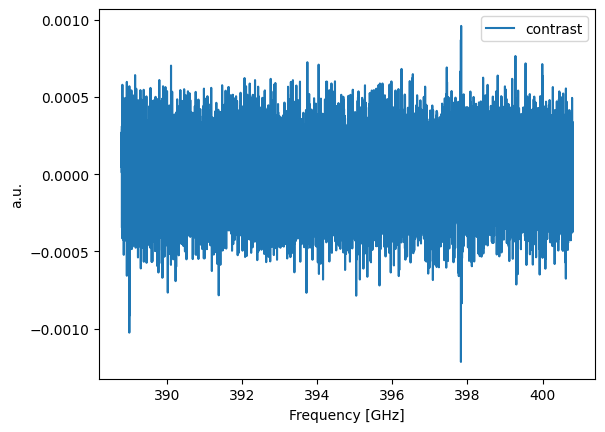

In [65]:
import matplotlib.pyplot as plt
contrast = (signal-background)/background
idx = np.argmin(contrast)
print(f"Guess NV transition: {freq_actual[idx]*24}GHz")
shift = np.mean(background+signal)/2.0
# shift = 0
# plt.plot(freq_actual*24.0, signal-shift+0.0015, label="signal")
# plt.plot(freq_actual*24.0, background-shift+0.001, label="ref")
plt.plot(freq_actual*24.0, contrast, label="contrast")
# idxr = 500
# plt.plot(freq_actual[idx-idxr:idx+idxr]*24.0, signal[idx-idxr:idx+idxr]-shift, label="signal")
# plt.plot(freq_actual[idx-idxr:idx+idxr]*24.0, background[idx-idxr:idx+idxr]-shift, label="ref")
# plt.plot(freq_actual[idx-idxr:idx+idxr]*24.0, contrast[idx-idxr:idx+idxr], label="contrast")
plt.xlabel("Frequency [GHz]")
plt.ylabel("a.u.")
plt.legend()
plt.show()

In [105]:
mwsyn.reboot()

<class 'bytes'>
b'\x01\x88\x89'
Command sent without loss:
0x01 0x88 0x89 
MW Synthesizer Rebooted!


In [67]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
readtask.close()
mwsyn.reboot()

MW Synthesizer Rebooted!


NV transition: 392.92176872491837GHz


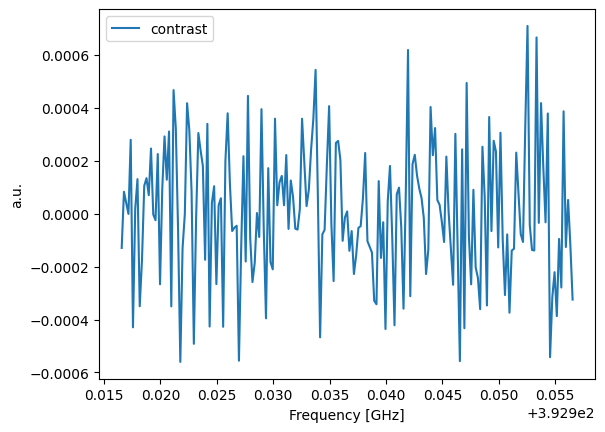

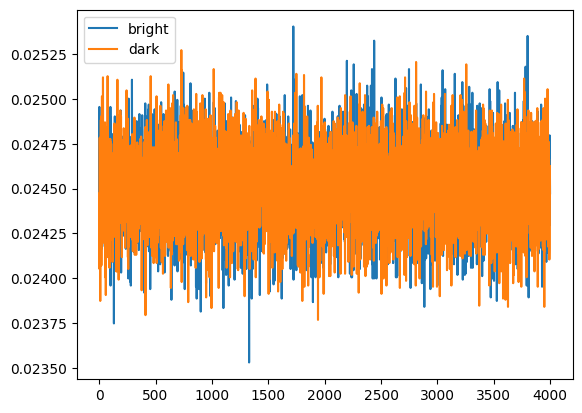

In [68]:

divnum = int(len(buffer_readpoint)/divpart_pt)
recordlen = int(divnum/2)
brightdata = np.zeros(recordlen*divpart_pt)
darkdata = np.zeros(recordlen*divpart_pt)
buffer_readpoint = np.append(buffer_readpoint, np.nan)
for ii in range(divpart_pt):
    brightdata[ii*recordlen:(ii+1)*recordlen] = buffer_readpoint[1+ii*divnum:1+ii*divnum+recordlen]
    # print(len(buffer_readpoint[1+ii*divnum+(divnum-recordlen):1+(ii+1)*divnum]))
    darkdata[ii*recordlen:(ii+1)*recordlen] = buffer_readpoint[1+ii*divnum+recordlen:1+(ii+1)*divnum]
np.delete(darkdata, -1)
plt.plot(brightdata, label="bright")
plt.plot(darkdata, label="dark")
# plt.plot(buffer_readpoint[divnum:divnum:])
plt.legend()
plt.show()

In [48]:
# close the communication
laser.close()
mwsyn.close()
pg.reset()